In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image

def reload_functions():
  if 'ShoePairClassifier' in sys.modules:
    del sys.modules['ShoePairClassifier']
  functions_path = drive_path.replace(" ","\ ") + 'ShoePairClassifier.py'
  !cp $functions_path .

In [5]:
from google.colab import drive
drive_path = '/content/drive/MyDrive/ShoePairClassifier' # UPDATE ME!
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
path = drive_path + "data/train/*.jpg"
path_m = drive_path + "data/test_m/*.jpg"
path_w = drive_path + "data/test_w/*.jpg"

images = {}
images_m = {}
images_w = {}

for file in glob.glob(path):
    filename = file.split("/")[-1]            # get the name of the .jpg file
    img = np.asarray(Image.open(file))        # read the image as a numpy array
    images[filename] = img[:, :, :3]          # remove the alpha channel

for file in glob.glob(path_m):
    filename = file.split("/")[-1]           # get the name of the .jpg file
    img = np.asarray(Image.open(file))       # read the image as a numpy array
    images_m[filename] = img[:, :, :3]          # remove the alpha channel

for file in glob.glob(path_w):
    filename = file.split("/")[-1]           # get the name of the .jpg file
    img = np.asarray(Image.open(file))       # read the image as a numpy array
    images_w[filename] = img[:, :, :3]          # remove the alpha channel
filenames = sorted(list(images.keys()))
filenames_m = sorted(list(images_m.keys()))
filenames_w = sorted(list(images_w.keys()))

train_filenames = filenames[:534]
valid_filenames = filenames[534:]

num_train_triplets = len(train_filenames) // 6
num_valid_triplets = len(valid_filenames) // 6
num_test_m_triplets = len(filenames_m) // 6
num_test_w_triplets = len(filenames_w) // 6

train_data = np.zeros((num_train_triplets, 3, 2, 224, 224, 3))
valid_data = np.zeros((num_valid_triplets, 3, 2, 224, 224, 3))
test_m_data  = np.zeros((num_test_m_triplets,3,2,224,224,3))
test_w_data  = np.zeros((num_test_w_triplets,3,2,224,224,3))

counter = 0
for t in range(num_train_triplets):
    for p in range(3):
        for s in range(2):
            img_index = t * 6 + p * 2 + s
            if img_index < len(train_filenames):
                filename = train_filenames[img_index]
                img = images[filename] / 255.0 - 0.5
                train_data[t, p, s, :, :, :] = img
                counter += 1
            else:
                break

print(f"Processed {counter} images into train_data")

counter = 0
for t in range(num_valid_triplets):
    for p in range(3):
        for s in range(2):
            img_index = t * 6 + p * 2 + s
            if img_index < len(valid_filenames):
                filename = valid_filenames[img_index]
                img = images[filename] / 255.0 - 0.5
                valid_data[t, p, s, :, :, :] = img
                counter += 1
            else:
                break

print(f"Processed {counter} images into valid_data")

counter = 0
for t in range(num_test_m_triplets):
    for p in range(3):
        for s in range(2):
            img_index = t*6 + p*2 + s
            if img_index < len(filenames_m):
                filename = filenames_m[img_index]
                img = images_m[filename] / 255.0 - 0.5
                test_m_data[t, p, s,:,:,:] = img
                counter += 1
            else:
                break
print(f"Processed {counter} images into test_m_data")

counter = 0
for t in range(num_test_w_triplets):
    for p in range(3):
        for s in range(2):
            img_index = t*6 + p*2 + s
            if img_index < len(filenames_w):
                filename = filenames_w[img_index]
                img = images_w[filename] / 255.0 - 0.5
                test_w_data[t, p, s,:,:,:] = img
                counter += 1
            else:
                break
print(f"Processed {counter} images into test_w_data")



NameError: name 'drive_path' is not defined

In [ ]:
print(train_data.shape)

(89, 3, 2, 224, 224, 3)


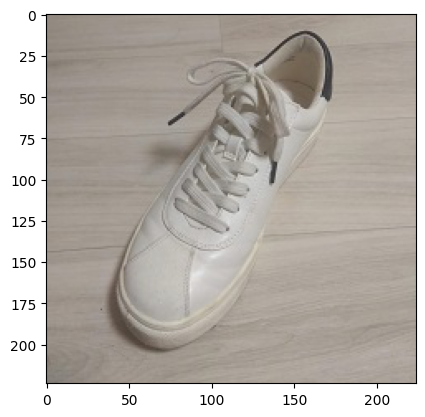

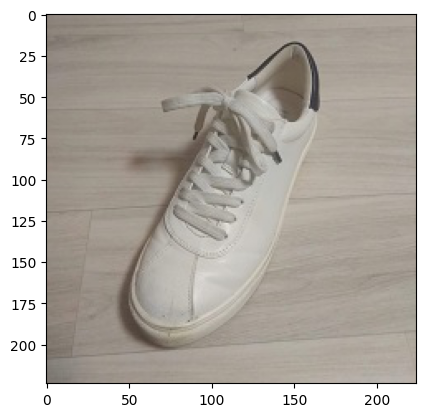

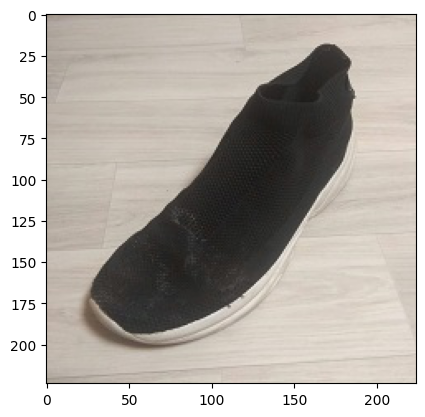

In [ ]:
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


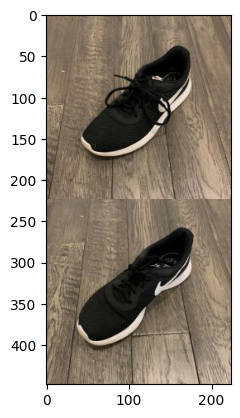

In [ ]:
def generate_same_pair(dataset):
  total_pairs = 3 * len(dataset)
  concatenated_images = np.zeros((total_pairs,448,224,3))

  idx = 0
  for i in range(len(dataset)):
    for j in range(3):
      concatenated_images[idx] = np.concatenate((dataset[i, j, 0], dataset[i, j, 1]), axis=0)
      idx += 1
  return concatenated_images

print(train_data.shape)
print(generate_same_pair(train_data).shape)
plt.imshow(generate_same_pair(train_data)[0]+0.5) #same pair of shoes

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


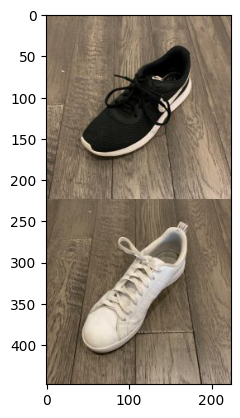

In [ ]:
def generate_different_pair(dataset):
  total_pairs = 3 * len(dataset)

  concatenated_images = np.zeros((total_pairs, 448, 224, 3))
  idx = 0
  for i in range(len(dataset)):
    for j in range(3):
      concatenated_images[idx] = np.concatenate((dataset[i, j, 0], dataset[i, (j+1)%3, 1]), axis=0)
      idx += 1
  return concatenated_images

print(train_data.shape)
print(generate_different_pair(train_data).shape)
plt.imshow(generate_different_pair(train_data)[0]+0.5) # different pair shoes

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_accuracy(model, data, batch_size=50,device='cpu'):
    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_model(model,
                train_data=train_data,
                validation_data=valid_data,
                batch_size=60,
                learning_rate=0.003,
                weight_decay=0.00001,
                epochs=85,
                checkpoint_path=None):
  model.to(device)
  # Initialize Loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  train_pos = generate_same_pair(train_data)
  train_neg = generate_different_pair(train_data)

  train_acc = get_accuracy(model, train_data, batch_size,device="cuda")
  valid_acc = get_accuracy(model, validation_data, batch_size,device="cuda")


  val_acc = []
  train_loss = []
  train_loss_sum = 0
  total_loss = 0

  for epoch in range(epochs):
    np.random.shuffle(train_neg)
    np.random.shuffle(train_pos)

    model.train()


    for i in range(0,len(train_pos),batch_size//2):
      pos_batch = train_pos[i:i + batch_size // 2,:,:,:]
      neg_batch = train_neg[i:i + batch_size // 2,:,:,:]

      inputs = np.concatenate((pos_batch, neg_batch), axis=0)
      labels = np.concatenate((np.ones(len(pos_batch)), np.zeros(len(neg_batch))))

      inputs = torch.tensor(inputs, dtype=torch.float).permute(0, 3, 1, 2) # Change NHWC to NCHW format
      labels = torch.tensor(labels, dtype=torch.long)

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()
      total_loss += loss.item()

    train_loss.append(loss.item())

    model.eval()
    val_i_pos , val_i_neg = get_accuracy(model, validation_data,batch_size,device='cuda')
    val_acc.append((val_i_pos + val_i_neg // 2))

    print("Epoch: ",epoch ,"loss: ",loss.item(),"val: ",(val_i_pos + val_i_neg // 2), )
    if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")


  return train_loss, val_acc


Epoch:  0 loss:  0.7170469760894775 val:  0.0
Epoch:  1 loss:  0.7076631784439087 val:  0.36231884057971014
Epoch:  2 loss:  0.6990761756896973 val:  0.8985507246376812
Epoch:  3 loss:  0.6847096085548401 val:  0.43478260869565216
Epoch:  4 loss:  0.6984879970550537 val:  0.5362318840579711
Epoch:  5 loss:  0.6958445906639099 val:  0.4782608695652174
Epoch:  6 loss:  0.6967929601669312 val:  0.4057971014492754
Epoch:  7 loss:  0.710027277469635 val:  0.8405797101449275
Epoch:  8 loss:  0.7032241821289062 val:  0.8840579710144928
Epoch:  9 loss:  0.6775015592575073 val:  0.4927536231884058
Epoch:  10 loss:  0.6823203563690186 val:  0.7391304347826086
Epoch:  11 loss:  0.6683221459388733 val:  0.9130434782608695
Epoch:  12 loss:  0.6384243369102478 val:  0.782608695652174
Epoch:  13 loss:  0.6790064573287964 val:  0.9710144927536232
Epoch:  14 loss:  0.5743414759635925 val:  0.8840579710144928
Epoch:  15 loss:  0.4771537780761719 val:  0.9420289855072463
Epoch:  16 loss:  0.4582231044769

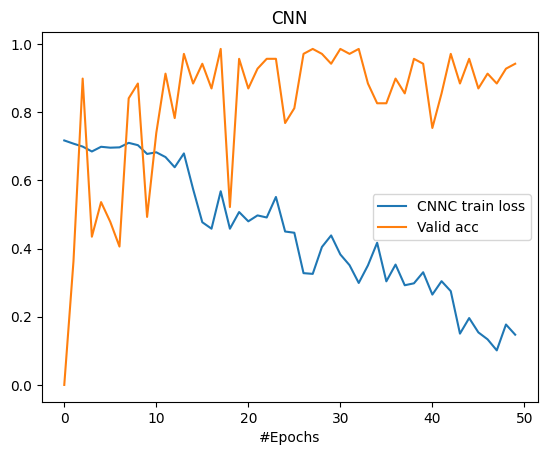

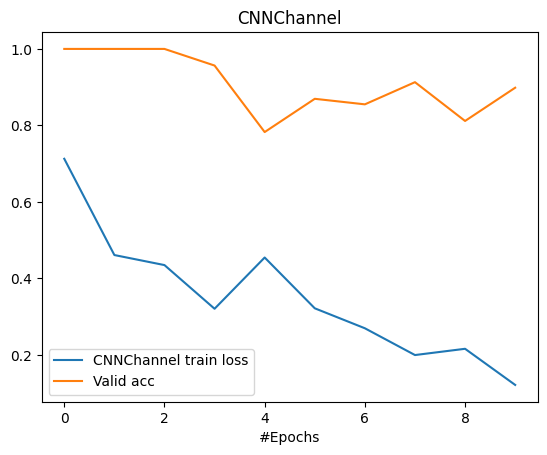

In [ ]:
reload_functions()
import ML_DL_Functions3
CNN_model = ML_DL_Functions3.CNN()
CNNChannel_model = ML_DL_Functions3.CNNChannel()

# Insert your training here
t_l0,bb= train_model(CNN_model, train_data, valid_data,learning_rate = 0.001,epochs=50,batch_size=50,weight_decay = 0.000001)

t_l,bb1 = train_model(CNNChannel_model, train_data, valid_data,learning_rate = 0.001,epochs = 10,batch_size=80,weight_decay = 0.000001)

plt.plot(t_l0,label='CNNC train loss')
plt.plot(bb, label='Valid acc')

# Adding labels and title
plt.xlabel('#Epochs')
plt.title('CNN')
# Adding a legend
plt.legend()
# Show the plot
plt.show()


plt.plot(t_l, label='CNNChannel train loss')
plt.plot(bb1, label='Valid acc')

# Adding labels and title
plt.xlabel('#Epochs')
plt.title('CNNChannel')
# Adding a legend
plt.legend()
# Show the plot
plt.show()







In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
checkpoints  data  ML_DL_Assignment3.ipynb  ML_DL_Functions3.py


In [ ]:
checkpoint_path  = drive_path +"checkpoints/"
torch.save(CNN_model.state_dict(), checkpoint_path + "CNN_model.pk")
torch.save(CNNChannel_model.state_dict(), checkpoint_path+"CNNChannel_model.pk")

In [ ]:
!ls /content/drive/MyDrive/Intro_To_ML/assigment3_new_try/checkpoints

best_CNNChannel_model.pk  best_CNN_model.pk


In [ ]:
#-----------------testing------------------

reload_functions()
import ML_DL_Functions3
best_CNN_model = ML_DL_Functions3.CNN()
best_CNNChannel_model = ML_DL_Functions3.CNNChannel()

best_CNN_model.load_state_dict(torch.load(checkpoint_path+"best_CNN_model.pk"))
best_CNNChannel_model.load_state_dict(torch.load(checkpoint_path+"best_CNNChannel_model.pk"))

best_CNN_model = best_CNN_model.to(device)
best_CNNChannel_model = best_CNNChannel_model.to(device)

best_CNN_model.eval()
best_CNNChannel_model.eval()

m_pos_cnnc , m_neg_cnnc = get_accuracy(best_CNNChannel_model, test_m_data, device='cuda')
w_pos_cnnc , w_neg_cnnc = get_accuracy(best_CNNChannel_model, test_w_data, device='cuda')

avr_cnnc = (m_pos_cnnc+m_neg_cnnc+w_pos_cnnc+w_neg_cnnc)/4

m_pos_cnn , m_neg_cnn = get_accuracy(best_CNN_model, test_m_data, device='cuda')
w_pos_cnn , w_neg_cnn = get_accuracy(best_CNN_model, test_w_data, device='cuda')

avr_cnn = (m_pos_cnn+m_neg_cnn+w_pos_cnn+w_neg_cnn)/4

print("CNNChannel Accuracies:")
print(f"test_pos_cnnc_m: {m_pos_cnnc}, test_neg_cnnc_m: {m_neg_cnnc}, test_pos_cnnc_w: {w_pos_cnnc}, test_neg_cnnc_w: {w_neg_cnnc}")

print("CNNChannel:", avr_cnnc * 100, "%")

print("CNN Accuracies:")

print(f"test_pos_cnn_m: {m_pos_cnn}, test_neg_cnn_m: {m_neg_cnn}, test_pos_cnn_w: {w_pos_cnn}, test_neg_cnn_w: {w_neg_cnn}")


print("CNN:", avr_cnn * 100, "%")


CNNChannel Accuracies:
test_pos_cnnc_m: 0.8666666666666667, test_neg_cnnc_m: 0.8, test_pos_cnnc_w: 0.8666666666666667, test_neg_cnnc_w: 0.8333333333333334
CNNChannel: 84.16666666666667 %
CNN Accuracies:
test_pos_cnn_m: 0.9333333333333333, test_neg_cnn_m: 0.7666666666666667, test_pos_cnn_w: 0.9333333333333333, test_neg_cnn_w: 0.7666666666666667
CNN: 85.00000000000001 %


CNN model correctly classified same pair:


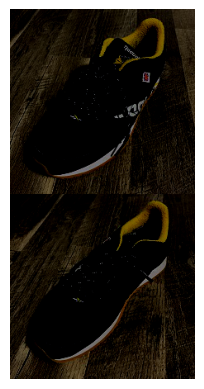

CNN model incorrectly classified different pair:


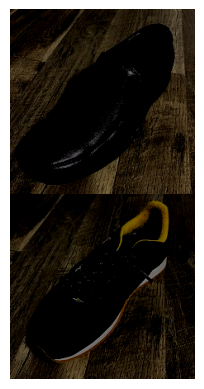

CNNChannel model correctly classified same pair:


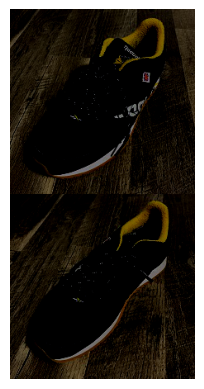

CNNChannel model incorrectly classified different pair:


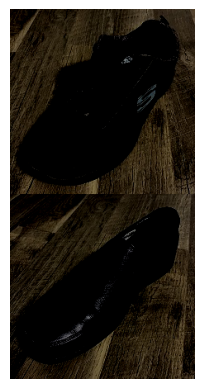

In [ ]:
from re import X
def print_func(model, data, device='cpu'):
    model.eval()
    data_pos = generate_same_pair(data)      # Positive pairs
    data_neg = generate_different_pair(data) # Negative pairs
    model_name = "CNN" if isinstance(model, ML_DL_Functions3.CNN) else "CNNChannel"

    # Function to check and display images
    def check_and_display(data, expected_pred, message):
        for img in data:
            X = torch.Tensor([img]).permute(0, 3, 1, 2).to(device)
            pred = model(X).max(1)[1].item()
            if pred == expected_pred:
                print(f"{model_name} model {message}:")
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                return True
        return False

    # Display examples
    if not check_and_display(data_pos, 1, "correctly classified same pair"):
        print("No correctly classified positive example found.")
    if not check_and_display(data_neg, 0, "incorrectly classified different pair"):
        print("No incorrectly classified negative example found.")

# Example usage
print_func(best_CNN_model, test_m_data, "cuda")
print_func(best_CNNChannel_model, test_m_data, "cuda")

